In [1]:
import os
from sklearn.model_selection import train_test_split
import pandas as pd
import sklearn.metrics as sk_metrics
import matplotlib.pyplot as plt
import sklearn.neural_network._multilayer_perceptron as sk_mlp
import sklearn.naive_bayes as sk_nb
import numpy as np



class_to_code = {
    0: 4,
    1: 33,
    2: 34,
    3: 35,
    4: 36,
    5: 48,
    6: 56,
    7: 57,
    8: 58,
    9: 59,
    10: 60,
    11: 61,
    12: 62,
    13: 63,
    14: 64,
    15: 65,
    16: 66,
    17: 67,
    18: 68,
    19: 69,
    20: 70,
    21: 71,
    22: 72,
}

code_to_class = {
    4: 0,
    33: 1,
    34: 2,
    35: 3,
    36: 4,
    48: 5,
    56: 6,
    57: 7,
    58: 8,
    59: 9,
    60: 10,
    61: 11,
    62: 12,
    63: 13,
    64: 14,
    65: 15,
    66: 16,
    67: 17,
    68: 18,
    69: 19,
    70: 20,
    71: 21,
    72: 22,
}


def categorize_time(time_str):
    hour, minute = map(int, time_str.split(':'))
    total_minutes = hour * 60 + minute
    # Podziel czas na 48 równych przedziałów
    category = int(total_minutes // ((24 * 60) / 48)) + 1
    return category

class Data:
    def __init__(self, data):
        self.date = data.get("date", "")
        self.time = data.get("time", "")
        self.code = data.get("value1", 0)
        self.insuline = data.get("value2", 0)


def process_line_content(line):
    components = line.strip().split("\t")

    try:
        date, time, value1, value2 = components
    except Exception as e:
        return None

    try:
        value1 = int(value1.lstrip("0") if value1.lstrip("0") else 0)
    except Exception as e:
        pass

    try:
        value2 = int(value2.lstrip("0") if value2.lstrip("0") else 0)
    except Exception as e:
        return None
    data = {
        "date": date,
        "time": time,
        "code": value1,
        "insuline": value2,
    }

    return data


def read_data_from_files(tar_file_path):
    aLL_patients_data = []
    files = os.listdir(tar_file_path)

    data_files = [file for file in files if file.startswith("data-")]

    for data_file in data_files:
        file_path = os.path.join(tar_file_path, data_file)
        with open(file_path, "r") as file_content:
            for line in file_content:
                patient_data = process_line_content(line)
                if patient_data:
                    aLL_patients_data.append(patient_data)


    return aLL_patients_data


def split_data(files_path, test_size=0.2):
    patients_data = read_data_from_files(files_path)
    df = pd.DataFrame(patients_data)

    X = df.drop(["code"], axis=1).drop(["date"], axis=1)
    X["time"] = X["time"].apply(categorize_time)
    y = df["code"]

    X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=test_size, random_state=42)
    return  X_train.values, X_test.values, y_train.values, y_test.values

## Split_data

- Read data from files from directory and combine them into one dataframe.
- Remove not used `date` column and extract `code` column as target values
- Convert `code` and `time` columns to numeric values
- Split data into train and test sets.

# Naive Bayes Classifier

This classifier is particularly suitable for classification tasks and assumes that the features are conditionally independent given the class label.

## Class Structure

The `NaiveBayesClassifier` class has the following attributes:

- `class_probs`: A dictionary to store the probabilities of each class.
- `feature_probs`: A nested dictionary to store the probabilities of each feature given a class.

## `fit` Method

The `fit` method is responsible for training the Naive Bayes classifier with the provided training data (`X` and `y`).

1. **Class Probabilities:**
   - Iterate over each unique class label.
   - Calculate and store the probability of each class in the `class_probs` dictionary.

2. **Feature Probabilities:**
   - Iterate over each unique class label.
   - For each class, create a nested dictionary in `feature_probs` to store feature probabilities.
   - Calculate and store the probability of each feature value given the class.

## `predict` Method

The `predict` method is used to make predictions on new data (`X`) using the trained classifier.

1. **Prediction Loop:**
   - Iterate over each sample in the input data.
   - Initialize variables to keep track of the maximum probability (`max_prob`) and the predicted label (`predicted_label`).

2. **Class Probability Calculation:**
   - For each class, calculate the probability based on class probabilities and feature probabilities for the given sample.

3. **Feature Probability Calculation:**
   - For each feature in the sample, multiply the probability by the conditional probability of the feature given the class.
   - If a feature value is not observed in the training data for a particular class, the probability is set to 0.

4. **Prediction:**
   - Choose the class with the highest calculated probability as the predicted label for the current sample.
   - Append the predicted label to the list of predictions.

5. **Result:**
   - Return the list of predictions for all samples.

This implementation follows the principles of the Naive Bayes algorithm, assuming independence between features given the class label.


In [2]:
class NaiveBayesClassifier:
    def __init__(self):
        self.class_probs = {}
        self.feature_probs = {}

    def fit(self, X, y):
        total_samples = len(y)
        y_temp = list(y)
        for label in set(y):
            self.class_probs[label] = y_temp.count(label) / total_samples

        num_features = len(X[0])
        for label in set(y):
            self.feature_probs[label] = {i: {} for i in range(num_features)}
            label_indices = [i for i, lb in enumerate(y) if lb == label]
            for feature_index in range(num_features):
                feature_values = set(X[i][feature_index] for i in label_indices)
                for value in feature_values:
                    count = sum(1 for i in label_indices if X[i][feature_index] == value)
                    self.feature_probs[label][feature_index][value] = count / len(label_indices)

    def predict(self, X):
        predictions = []
        predicted_probabilities = []
        for index, sample in enumerate(X):
            probas = []
            max_prob = -1
            predicted_label = None
            for label in self.class_probs:
                prob = self.class_probs[label]
                for feature_index, value in enumerate(sample):
                    if value in self.feature_probs[label][feature_index]:
                        prob *= self.feature_probs[label][feature_index][value]
                    else:
                        prob = 0
                        break

                if prob > max_prob:
                    max_prob = prob
                    predicted_label = label
                probas.append(prob)

            predictions.append(predicted_label)
            probas.append(0)
            predicted_probabilities.append(probas)

        predicted_probabilities = np.array(predicted_probabilities)

        return predictions, predicted_probabilities

In [25]:
def create_roc_curve(y_test, probabilities=None):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    possible_predictions = np.unique(y_test)
    for class_id in range(22):
        y = y_test[:, class_id]
        prob = probabilities[:, class_id]
        fpr, tpr, _ = sk_metrics.roc_curve(y, prob)
        roc_auc = sk_metrics.auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"Code {class_id} vs Rest, auc={roc_auc:.2f}")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

C:\Users\KMult\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KMult\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KMult\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive sam

Naive Bayes results
Accuracy: 0.7907175886281897
Precision: 0.7638623416937633
Recall: 0.7907175886281897


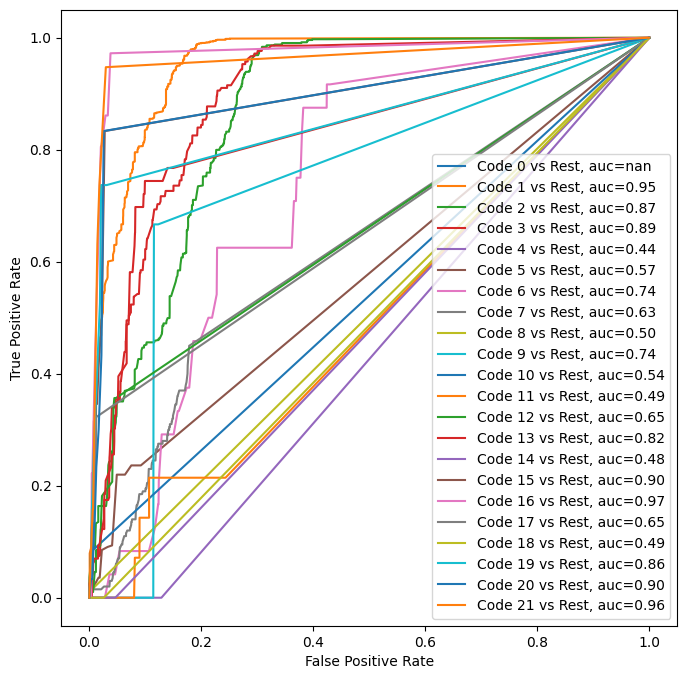

C:\Users\KMult\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KMult\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KMult\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive sam

Sklearn results
Accuracy: 0.7523548552834389
Precision: 0.6631091435812702
Recall: 0.7523548552834389


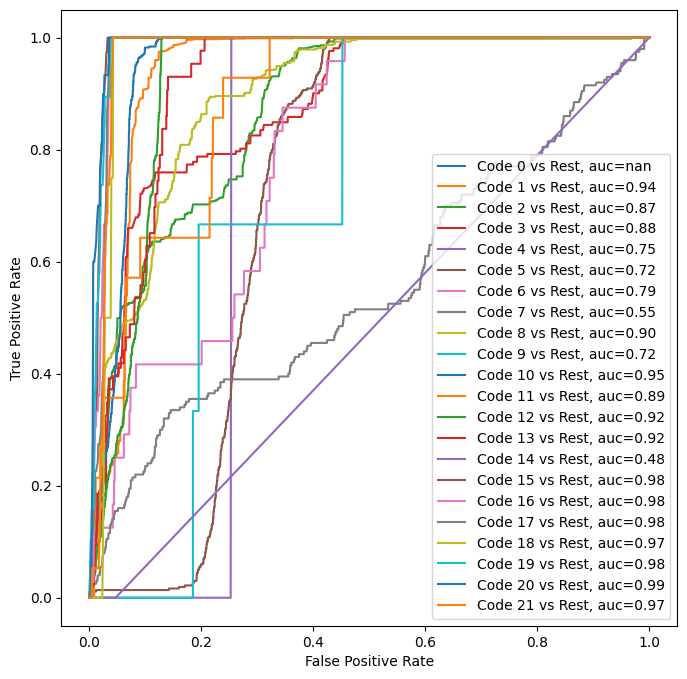

In [26]:
files_path = "Diabetes-Data"
X_train, X_test, y_train, y_test = split_data(files_path)

all_y = np.concatenate( (y_train, y_test) )
unique_y = np.unique(all_y)
output_size = len(unique_y)

nb_classifier = NaiveBayesClassifier()
nb_classifier.fit(X_train, y_train)
predictions, probabilities = nb_classifier.predict(X_test)

accuracy = sk_metrics.accuracy_score(y_test, predictions)
precision = sk_metrics.precision_score(y_test, predictions, average='weighted')
recall = sk_metrics.recall_score(y_test, predictions, average='weighted')

print(f"Naive Bayes results")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


for i in range(len(y_test)):
    y_test[i] = code_to_class[y_test[i]]
    predictions[i] = code_to_class[predictions[i]]
y_test = np.eye(output_size)[y_test]

create_roc_curve(y_test, probabilities)


sk_nb_classifier = sk_nb.GaussianNB()
sk_nb_classifier.fit(X_train, y_train)
sk_predictions = sk_nb_classifier.predict(X_test)
sk_probabilities = sk_nb_classifier.predict_proba(X_test)


for i in range(len(sk_predictions)):
    sk_predictions[i] = code_to_class[sk_predictions[i]]
sk_predictions = np.eye(output_size)[sk_predictions]


sk_accuracy1 =  sk_metrics.accuracy_score(y_test, sk_predictions)
sk_precision = sk_metrics.precision_score(y_test, sk_predictions, average='weighted')
sk_recall = sk_metrics.recall_score(y_test, sk_predictions, average='weighted')

print(f"Sklearn results")
print(f"Accuracy: {sk_accuracy1}")
print(f"Precision: {sk_precision}")
print(f"Recall: {sk_recall}")
create_roc_curve(y_test, sk_probabilities)


<bold>My Naive Bayes Classifier have slightly better metrics than that provided from sklearn library.
Naive Bayes is also better than Multilayer Perceptron Classifier in this case because it is faster and more accurate.
Naive Bayes is great at handling large amounts of data that is why it is probably better than Multilayer Perceptron Classifier in this situation.</bold>